## Домашнее задание Numpy Neural Net Exploration (50 баллов)

В этом домашнем задании требуется провести набор экспериментов с нейронной сетью. Для проведения экспериментов нужно доработать представленный фреймворк для обучения нейронной сети на Numpy в проекте **Numpy_NN** c **hinge_loss** функцией ошибки. 


Все необходимые доработки обозначены в проекте `Numpy_NN` тегом **TODO**.

В ноутбуке только сами эксперименты с помощью данных команд - все доработки делать внутри фреймворка.

In [2]:
# Пример импорта модуля
import glob
import pickle
import numpy as np
import os
import sys
sys.path.append(os.path.join(os.getcwd(), "Numpy_NN/src"))

from nn.module import sequential

# пример быстрой перезагрузки модуля без рестарта ноутбука
import importlib
importlib.reload(sequential)

<module 'nn.module.sequential' from '/home/jupyter/work/resources/DeepLearning_Sber/Numpy Network/Numpy_NN/src/nn/module/sequential.py'>

Вам нужно провести набор экспериментов с CIFAR датасетом и исследовать поведение нейронной сети на этом датасете при разных архитектурах. Пример 1ого эксперимента можно найти в ноутбуке ``Numpy Network/Numpy_NN/test_CIFAR_training.ipynb``

Ваши эксперименты должы быть логичны - старайтесь последовательно строить архитектуру и попытайтесь к концу эксприментов определить комбинацию компонент нейронной сети для лучшего качества. Также же вы можете расширять количеcтво экспериментов, подтверждая это соответсвующими выводами. 

В каждом эксперименте должен быть:
    
    * Процесс обучения нейронной сети с помощью training.train.train
    * Проверка градиента для каждой архитектуры нейронной сети с помощью utils.gradient_check(если это указано в описании эксперимента)
    * Визуализация обучения - воспользоваться методом visualization_utils.plot_learning_curves
    * Рассчет точности общей точности модели и рассчет по классовой точности с помощью sklearn.metrics.classification_report
    * Ваш вывод по результату эксперимента
    
В каждом эксперименте должен быть каждый пункт иначе эксперимент не оценивается. Каждый эксперимент оценивается в **4 балла**. За расширение пространства экспериментов и реализации своих идей можно дополнительно получить до **6 баллов**.

В данном ДЗ оценивается качество работы доработанного вами фреймворка, качество проведения эксперимента и полученный результат. 

### Для начала проанализируем датасет и разделим на три части
Этот ход скопирован из примера

In [3]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2024-02-23 09:13:02--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz.3’

     0K .......... .......... .......... .......... ..........  0%  187K 14m51s
    50K .......... .......... .......... .......... ..........  0%  372K 11m9s
   100K .......... .......... .......... .......... ..........  0% 52.1M 7m27s
   150K .......... .......... .......... .......... ..........  0%  374K 7m26s
   200K .......... .......... .......... .......... ..........  0% 32.7M 5m58s
   250K .......... .......... .......... .......... ..........  0% 33.4M 4m59s
   300K .......... .......... .......... .......... ..........  0%  382K 5m18s
   350K .......... .......... .......... .......... ..........  0% 33.0M 4m39s
  

И распакуем его

In [36]:
!tar -xzf cifar-10-python.tar.gz

На выходе будем иметь следующие файлы

In [3]:
files = glob.glob("cifar-10-batches-py/**")
files = [item.split('/')[-1] for item in files]
for file in sorted(files):
    print(f"-{file}")

-batches.meta
-data_batch_1
-data_batch_2
-data_batch_3
-data_batch_4
-data_batch_5
-readme.html
-test_batch


Из этих файлов нас интересуют data_batch_1, data_batch_2, ..., data_batch_5 -- это файлы с тренировочными данными, и файл test_batch -- это файл с тестовыми данными, на которых мы будем измерять свои метрики.

Посмотрим ближе на структуру файлов

In [4]:
with open("cifar-10-batches-py/data_batch_1", "rb") as f:
    train_dataset_1 = pickle.load(f, encoding="bytes")

Датасет содержит следующие ключи:

In [5]:
for key in train_dataset_1.keys():
    print(f"-{key.decode('utf-8')}")

-batch_label
-labels
-data
-filenames


Ключ `batch_label` нас не интересует, так как содержит только лишь информацию о номере бача

In [6]:
train_dataset_1[b'batch_label'].decode('utf-8')

'training batch 1 of 5'

Ключ `filenames` в данном случае нас тоже не интересует, так как он содержит названия файлов, которые мы без привлечения языковых моделей использовать не сможем

In [7]:
print("Первые 10 названий:")
for name in train_dataset_1[b'filenames'][:10]:
    print(f"-{name.decode('utf-8')}")

Первые 10 названий:
-leptodactylus_pentadactylus_s_000004.png
-camion_s_000148.png
-tipper_truck_s_001250.png
-american_elk_s_001521.png
-station_wagon_s_000293.png
-coupe_s_001735.png
-cassowary_s_001300.png
-cow_pony_s_001168.png
-sea_boat_s_001584.png
-tabby_s_001355.png


Остаются два наиболее интересных ключа, это `data` и `labels`.

Как нетрудно догадаться, `labels` содержит классы. Выведем первые 10 элементов:

In [8]:
print(train_dataset_1[b'labels'][:10])

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]


Классы представлены числовыми метками. В принципе нам нет необходимости знать соответствие между ними, однако эти данные можно найти в файле `batches.meta`:

In [9]:
with open("cifar-10-batches-py/batches.meta", "rb") as f:
    classes_names = pickle.load(f, encoding="bytes")

for ind, name in enumerate(classes_names[b'label_names']):
    print(f"{ind}: {name.decode('utf-8')}")

0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


Ключ `data` содержит уже сами числовые данные

In [10]:
print(f"Количество данных: {len(train_dataset_1[b'data'])}")
print(f"Размер вектора: {train_dataset_1[b'data'][0].shape}")

Количество данных: 10000
Размер вектора: (3072,)


Теперь интересно посмотреть на сбалансированность меток по разбиениям. Для этого загрузим все тестовые разбиения

In [11]:
with open("cifar-10-batches-py/data_batch_2", "rb") as f:
    train_dataset_2 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_3", "rb") as f:
    train_dataset_3 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_4", "rb") as f:
    train_dataset_4 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_5", "rb") as f:
    train_dataset_5 = pickle.load(f, encoding="bytes")

И посчитаем сколько раз каждая метка встречается в каждом датасете

In [12]:
datasets = [train_dataset_1, train_dataset_2, train_dataset_3, 
            train_dataset_4, train_dataset_5]

labels = list(range(10))

print("|=====|{}|{}|{}|{}|{}|{}|".format(
    "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6))
print("|Label|{0:^{1}}|{2:^{3}}|{4:^{5}}|{6:^{7}}|{8:^{9}}|{10:^{11}}|".format(
    "Data 1", 6, "Data 2", 6, "Data 3", 6, "Data 4", 6, "Data 5", 6, "Sum", 6))
print("|=====|{}|{}|{}|{}|{}|{}|".format(
    "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6))

for label in labels:
    print("|{0:^{1}}|".format(label, 5), end='')
    label_num = 0
    for dataset in datasets:
        print("{0:^{1}}|".format(dataset[b'labels'].count(label), 6), end='')
        label_num += dataset[b'labels'].count(label)
    print("{0:^{1}}|".format(label_num, 6))

print("|=====|{}|{}|{}|{}|{}|{}|".format(
    "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6))

|=====|======|======|======|======|======|======|
|Label|Data 1|Data 2|Data 3|Data 4|Data 5| Sum  |
|=====|======|======|======|======|======|======|
|  0  | 1005 | 984  | 994  | 1003 | 1014 | 5000 |
|  1  | 974  | 1007 | 1042 | 963  | 1014 | 5000 |
|  2  | 1032 | 1010 | 965  | 1041 | 952  | 5000 |
|  3  | 1016 | 995  | 997  | 976  | 1016 | 5000 |
|  4  | 999  | 1010 | 990  | 1004 | 997  | 5000 |
|  5  | 937  | 988  | 1029 | 1021 | 1025 | 5000 |
|  6  | 1030 | 1008 | 978  | 1004 | 980  | 5000 |
|  7  | 1001 | 1026 | 1015 | 981  | 977  | 5000 |
|  8  | 1025 | 987  | 961  | 1024 | 1003 | 5000 |
|  9  | 981  | 985  | 1029 | 983  | 1022 | 5000 |
|=====|======|======|======|======|======|======|


Как видим, данные не сбалансированы по разбиениям, поэтому объединим все в один датасет и разобьем это на два датасета, тренировочный и валидационный, при этом сразу поделим значения каждого вектора на 256, чтобы иметь интенсивность в относительных единицах (хотя максимум на 255)

In [13]:
train_dataset = []

for dataset in datasets:
    for vec, label in zip(dataset[b'data'], dataset[b'labels']):
        train_dataset.append((vec / 256, label))

На валидационную выборку оставим 10000 элементов, по 1000 примеров из каждого класса, выбранных случайно

In [14]:
np.random.seed(42)
np.random.shuffle(train_dataset)

train_data = []
valid_data = []

cnt = {ind: 0 for ind in range(10)}

for vec, label in train_dataset:
    if cnt[label] < 1000:
        cnt[label] += 1
        valid_data.append((vec, label))
    else:
        train_data.append((vec, label))

Подготовим еще тестовый датасет

In [15]:
with open("cifar-10-batches-py/test_batch", "rb") as f:
    test_dataset = pickle.load(f, encoding="bytes")

test_data = []
for vec, label in zip(test_dataset[b'data'], test_dataset[b'labels']):
    test_data.append((vec / 256, label))

Посмотрим на статистики

In [16]:
print("|=====|{}|{}|{}|{}|".format("=" * 6, "=" * 6, "=" * 6, "=" * 6))
print("|Label|{0:^{1}}|{2:^{3}}|{4:^{5}}|{6:^{7}}|".format(
    "Train", 6, "Valid", 6, "Test", 6, "Sum", 6))
print("|=====|{}|{}|{}|{}|".format("=" * 6, "=" * 6, "=" * 6, "=" * 6))

labels = list(range(10))
for label in labels:
    print("|{0:^{1}}|".format(label, 5), end='')
    label_num = 0
    for dataset in (train_data, valid_data, test_data):
        labels_data = [item[1] for item in dataset]
        print("{0:^{1}}|".format(labels_data.count(label), 6), end='')
        label_num += labels_data.count(label)
    print("{0:^{1}}|".format(label_num, 6))

print("|=====|{}|{}|{}|{}|".format("=" * 6, "=" * 6, "=" * 6, "=" * 6))

|=====|======|======|======|======|
|Label|Train |Valid | Test | Sum  |
|=====|======|======|======|======|
|  0  | 4000 | 1000 | 1000 | 6000 |
|  1  | 4000 | 1000 | 1000 | 6000 |
|  2  | 4000 | 1000 | 1000 | 6000 |
|  3  | 4000 | 1000 | 1000 | 6000 |
|  4  | 4000 | 1000 | 1000 | 6000 |
|  5  | 4000 | 1000 | 1000 | 6000 |
|  6  | 4000 | 1000 | 1000 | 6000 |
|  7  | 4000 | 1000 | 1000 | 6000 |
|  8  | 4000 | 1000 | 1000 | 6000 |
|  9  | 4000 | 1000 | 1000 | 6000 |
|=====|======|======|======|======|


Перед обучением отнормируем все данные

In [17]:
train_matrix = np.array([item[0] for item in train_data])
D = np.var(train_matrix, axis=0)
E = np.mean(train_matrix, axis=0)

for ind in range(len(train_data)):
    train_data[ind] = (train_data[ind][0] - E, train_data[ind][1])
    train_data[ind] = (train_data[ind][0] / np.sqrt(D), train_data[ind][1])

for ind in range(len(valid_data)):
    valid_data[ind] = (valid_data[ind][0] - E, valid_data[ind][1])
    valid_data[ind] = (valid_data[ind][0] / np.sqrt(D), valid_data[ind][1])

for ind in range(len(test_data)):
    test_data[ind] = (test_data[ind][0] - E, test_data[ind][1])
    test_data[ind] = (test_data[ind][0] / np.sqrt(D), test_data[ind][1])

In [18]:
from dataset.dataloader import Dataloader
from nn.module.sequential import Sequential
from nn.layers.linear import Linear
from nn.layers.batch_norm import BatchNorm
from nn.layers.dropout import Dropout
from nn.activations.relu import ReLU
from nn.activations.sigmoid import Sigmoid
from nn.activations.tanh import Tanh
from optimization.adam_optimizer import Adam
from nn import loss_functions
from training.train import train
from nn.loss_functions.hinge_loss import hinge_loss
from utils import gradient_check
import visualization_utils as viz_utils

from sklearn.metrics import classification_report

### Эксперимент 1 Построение нейронной сети с ReLU функцией активации

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации на ваше усмотрение, но указанная в эксперименте функция должна быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.  

Построим простую трехслойную модель

In [21]:
np.random.seed(42)

In [31]:
# проверка градиентов:
check_model = Sequential(
    Linear(3072, 128),
    ReLU(),
    Linear(128, 20),
    ReLU(),
    Linear(20, 10)
)
check_model

Sequential(
	Linear(3072, 128, bias=True),
	ReLU(),
	Linear(128, 20, bias=True),
	ReLU(),
	Linear(20, 10, bias=True)
)

In [32]:
x, y = Dataloader(train_data, batch_size=2).__next__()
print(f"Проверка{' не пройдена' if not gradient_check(x, y, check_model) else ''} пройдена")

Проверка пройдена                                                                           


In [43]:
# реальная модель
relu_model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 64),
    ReLU(),
    Linear(64, 10)
)
relu_model

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 64, bias=True),
	ReLU(),
	Linear(64, 10, bias=True)
)

In [44]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=relu_model, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000,
    optim_method="GD")

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  2.5452  | 0.1114  |  2.4171  | 0.1145  | 0.118055 |   6.2    |   6.2    |
| 2/10|  2.3546  | 0.1164  |  2.2710  | 0.1159  | 0.054959 |   7.3    |   13.6   |
| 3/10|  2.2267  | 0.1237  |  2.1671  | 0.1257  | 0.034753 |   6.2    |   19.8   |
| 4/10|  2.1337  | 0.1309  |  2.0896  | 0.1347  | 0.024401 |   6.0    |   25.8   |
| 5/10|  2.0634  | 0.1382  |  2.0303  | 0.1398  | 0.018062 |   6.0    |   31.8   |
| 6/10|  2.0086  | 0.1447  |  1.9836  | 0.1453  | 0.014250 |   6.0    |   37.8   |
| 7/10|  1.9647  | 0.1518  |  1.9457  | 0.1525  | 0.011337 |   6.6    |   44.4   |
| 8/10|  1.9286  | 0.1577  |  1.9143  | 0.1574  | 0.009815 |   5.9    |   50.3   |
| 9/10|  1.8983  | 0.1623  |  1.8877  | 0.1617  | 0.008413 |   6.2    |   56.5   |
|10/10|  1.8722  | 0.1670  |  1.8646  | 0.1653  | 0.007580 |   6.7    |   63.2   |


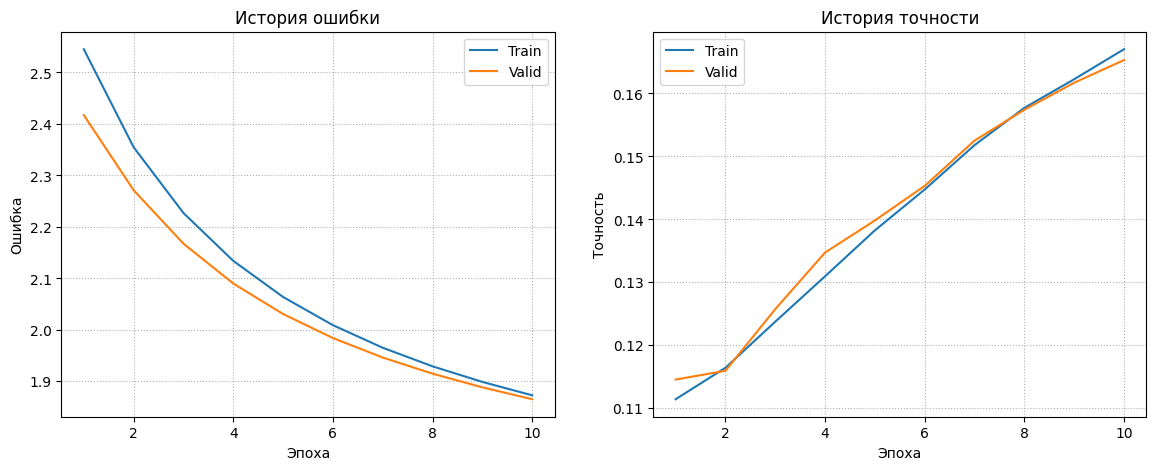

In [47]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [45]:
test_dataloader = Dataloader(test_data, len(test_data), False)
relu_model.eval()
for vecs, labels in test_dataloader:
    out = relu_model.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.8641
Точность на тесте: 0.1645


In [46]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.24      0.17      0.20      1000
           1       0.15      0.21      0.18      1000
           2       0.12      0.05      0.07      1000
           3       0.11      0.12      0.11      1000
           4       0.18      0.15      0.16      1000
           5       0.18      0.13      0.15      1000
           6       0.14      0.21      0.17      1000
           7       0.14      0.16      0.15      1000
           8       0.24      0.20      0.22      1000
           9       0.20      0.23      0.21      1000

    accuracy                           0.16     10000
   macro avg       0.17      0.16      0.16     10000
weighted avg       0.17      0.16      0.16     10000



##### Вывод  


### Эксперимент 2 Построение нейронной сети с Sigmoid функцией активации

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации на ваше усмотрение, но указанная в эксперименте функция должна быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.    

Построим простую трехслойную модель

In [21]:
np.random.seed(42)

In [22]:
# проверка градиентов:
check_model = Sequential(
    Linear(3072, 128),
    Sigmoid(),
    Linear(128, 20),
    Sigmoid(),
    Linear(20, 10)
)
check_model

Sequential(
	Linear(3072, 128, bias=True),
	Sigmoid(),
	Linear(128, 20, bias=True),
	Sigmoid(),
	Linear(20, 10, bias=True)
)

In [ ]:
x, y = Dataloader(train_data, batch_size=2).__next__()
print(f"Проверка{' не пройдена' if not gradient_check(x, y, check_model) else ''} пройдена")

Проверка пройдена                                                                                                                       ] 92/393216 0s>795s] 212/393216 0s>733s>                                                 ] 317/393216 0s>728s] 428/393216 0s>732s>                                                 ] 527/393216 0s>739s                                                 ] 756/393216 1s>732s>                                                 ] 842/393216 1s>746s1s>746s] 847/393216 1s>747s>                                                 ] 946/393216 1s>746s>                                                 ] 1164/393216 2s>745s 2s>738s>                                                 ] 1283/393216 2s>738s>                                                 ] 1395/393216 2s>736s1513/393216 2s>737s1602/393216 3s>738s                                                 ] 1620/393216 3s>737s                                                 ] 1698/393216 3s>743s1699/393216 3s>743s>          

In [ ]:
# реальная модель
sigmoid_model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 64),
    Sigmoid(),
    Linear(64, 10)
)
sigmoid_model

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 64, bias=True),
	Sigmoid(),
	Linear(64, 10, bias=True)
)

In [ ]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=sigmoid_model,
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000,
    optim_method="GD")

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.8072  | 0.0990  |  1.7624  | 0.1001  | 0.119939 |   9.6    |   9.6    |
| 2/10|  1.7389  | 0.1001  |  1.7043  | 0.0991  | 0.056202 |   9.6    |   19.3   |
| 3/10|  1.6859  | 0.1019  |  1.6583  | 0.0995  | 0.035030 |   9.6    |   28.9   |
| 4/10|  1.6428  | 0.1057  |  1.6192  | 0.1033  | 0.025901 |   9.6    |   38.6   |
| 5/10|  1.6056  | 0.1118  |  1.5849  | 0.1098  | 0.020634 |   9.5    |   48.1   |
| 6/10|  1.5727  | 0.1182  |  1.5546  | 0.1150  | 0.016886 |   9.8    |   57.9   |
| 7/10|  1.5436  | 0.1222  |  1.5275  | 0.1186  | 0.014277 |   9.9    |   67.8   |
| 8/10|  1.5175  | 0.1263  |  1.5027  | 0.1234  | 0.012619 |   9.9    |   77.8   |
| 9/10|  1.4934  | 0.1290  |  1.4795  | 0.1259  | 0.011138 |   9.7    |   87.5   |
|10/10|  1.4707  | 0.1301  |  1.4575  | 0.1267  | 0.010252 |   9.6    |   97.1   |


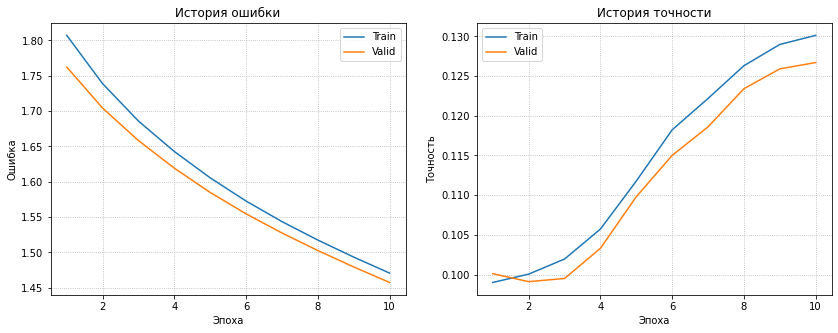

In [ ]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [28]:
test_dataloader = Dataloader(test_data, len(test_data), False)
sigmoid_model.eval()
for vecs, labels in test_dataloader:
    out = sigmoid_model.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.4566
Точность на тесте: 0.1277


In [29]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.20      0.17      0.18      1000
           1       0.12      0.28      0.16      1000
           2       0.11      0.27      0.16      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.10      0.24      0.14      1000
           7       0.00      0.00      0.00      1000
           8       0.16      0.32      0.22      1000
           9       0.08      0.00      0.00      1000

    accuracy                           0.13     10000
   macro avg       0.08      0.13      0.09     10000
weighted avg       0.08      0.13      0.09     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Вывод

### Эксперимент 3 Построение нейронной сети с TanH функцией активации

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации на ваше усмотрение, но указанная в эксперименте функция должна быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.   

In [30]:
np.random.seed(42)

In [31]:
# проверка градиентов:
check_model = Sequential(
    Linear(3072, 128),
    Tanh(),
    Linear(128, 20),
    Tanh(),
    Linear(20, 10)
)
check_model

Sequential(
	Linear(3072, 128, bias=True),
	Tanh(),
	Linear(128, 20, bias=True),
	Tanh(),
	Linear(20, 10, bias=True)
)

In [ ]:
x, y = Dataloader(train_data, batch_size=2).__next__()
print(f"Проверка{' не пройдена' if not gradient_check(x, y, check_model) else ''} пройдена")

Проверка пройдена                                                                           3s>                                                 ] 459/393216 0s>688s462/393216 0s>687s1s>680s>                                                 ] 705/393216 1s>670s>                                                 ] 710/393216 1s>671s1s>667s>                                                 ] 829/393216 1s>667s                                                 ] 830/393216 1s>669s1s>667s>                                                 ] 950/393216 1s>667s                                                 ] 1071/393216 1s>665s] 1074/393216 1s>664s>                                                 ] 1191/393216 2s>665s2s>662s2s>662s                                                 ] 1314/393216 2s>663s>                                                 ] 1427/393216 2s>663s                                                 ] 1430/393216 2s>664s                                                 ] 1523/39321

In [ ]:
# реальная модель
tanh_model = Sequential(
    Linear(3072, 768),
    Tanh(),
    Linear(768, 64),
    Tanh(),
    Linear(64, 10)
)
tanh_model

Sequential(
	Linear(3072, 768, bias=True),
	Tanh(),
	Linear(768, 64, bias=True),
	Tanh(),
	Linear(64, 10, bias=True)
)

In [ ]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=tanh_model,
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000,
    optim_method="GD")

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  2.3824  | 0.1272  |  2.2917  | 0.1226  | 0.120300 |   9.5    |   9.5    |
| 2/10|  2.2519  | 0.1336  |  2.1752  | 0.1282  | 0.057756 |   9.5    |   19.0   |
| 3/10|  2.1444  | 0.1399  |  2.0833  | 0.1359  | 0.032192 |   9.7    |   28.6   |
| 4/10|  2.0607  | 0.1476  |  2.0139  | 0.1476  | 0.022545 |   9.7    |   38.3   |
| 5/10|  1.9977  | 0.1545  |  1.9608  | 0.1561  | 0.016771 |   9.9    |   48.2   |
| 6/10|  1.9497  | 0.1609  |  1.9199  | 0.1630  | 0.012393 |   9.7    |   57.9   |
| 7/10|  1.9121  | 0.1660  |  1.8872  | 0.1688  | 0.011680 |   9.7    |   67.6   |
| 8/10|  1.8812  | 0.1708  |  1.8601  | 0.1747  | 0.010942 |   9.6    |   77.2   |
| 9/10|  1.8554  | 0.1754  |  1.8370  | 0.1796  | 0.008907 |   9.4    |   86.6   |
|10/10|  1.8331  | 0.1799  |  1.8170  | 0.1844  | 0.009833 |   9.5    |   96.1   |


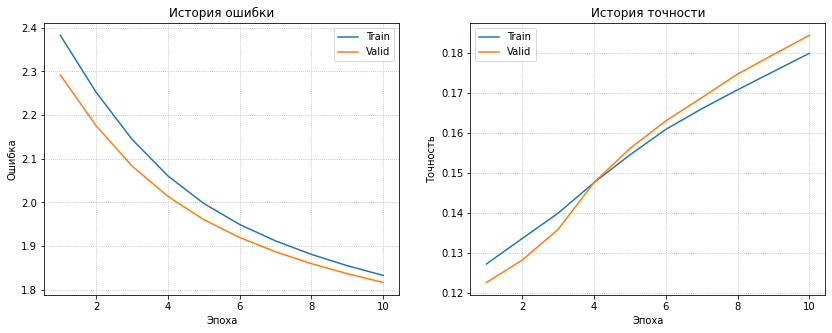

In [ ]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
tanh_model.eval()
for vecs, labels in test_dataloader:
    out = tanh_model.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.8298
Точность на тесте: 0.1772


In [ ]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.20      0.26      0.23      1000
           1       0.17      0.14      0.16      1000
           2       0.12      0.10      0.11      1000
           3       0.13      0.09      0.11      1000
           4       0.16      0.16      0.16      1000
           5       0.18      0.20      0.19      1000
           6       0.19      0.21      0.20      1000
           7       0.16      0.15      0.15      1000
           8       0.25      0.35      0.29      1000
           9       0.14      0.11      0.13      1000

    accuracy                           0.18     10000
   macro avg       0.17      0.18      0.17     10000
weighted avg       0.17      0.18      0.17     10000



### Эксперимент 4 Построение нейронной сети с Dropout слоем

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации, слои на ваше усмотрение, но указанный в эксперименте слой должен быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.  Подберите оптимальную вероятность в dropout. 

In [39]:
np.random.seed(42)

In [40]:
# проверка градиентов:
check_model = Sequential(
    Linear(3072, 128),
    ReLU(),
    Dropout(p=0.4),
    Linear(128, 20),
    ReLU(),
    Linear(20, 10)
)
check_model

Sequential(
	Linear(3072, 128, bias=True),
	ReLU(),
	Dropout(p=0.4),
	Linear(128, 20, bias=True),
	ReLU(),
	Linear(20, 10, bias=True)
)

In [ ]:
x, y = Dataloader(train_data, batch_size=2).__next__()
print(f"Проверка{' не пройдена' if not gradient_check(x, y, check_model) else ' пройдена'}")

Проверка пройдена                                                                           1021s] 233/393216 0s>1020s1s>875s>                                                 ] 451/393216 1s>875s>                                                 ] 452/393216 1s>874s                                                 ] 555/393216 1s>852s] 556/393216 1s>852s>                                                 ] 558/393216 1s>852s>                                                 ] 663/393216 1s>833s] 769/393216 1s>818s>                                                 ] 772/393216 1s>820s>                                                 ] 877/393216 1s>811s977/393216 2s>805s 2s>804s>                                                 ] 980/393216 2s>804s1084/393216 2s>797s 2s>798s] 1087/393216 2s>798s 2s>798s] 1191/393216 2s>794s>                                                 ] 1192/393216 2s>794s] 1294/393216 2s>791s1393/393216 2s>789s2s>790s>                                                 ] 139

In [ ]:
# реальная модель
dropout_model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Dropout(p=0.4),
    Linear(768, 64),
    ReLU(),
    Linear(64, 10)
)
dropout_model

Sequential(
	Linear(3072, 128, bias=True),
	ReLU(),
	Dropout(p=0.5),
	Linear(128, 20, bias=True),
	ReLU(),
	Linear(20, 10, bias=True)
)

In [ ]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=dropout_model, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000,
    optim_method="GD")

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  3.3682  | 0.0941  |  2.3961  | 0.0934  | 0.124316 |   2.6    |   2.6    |
| 2/10|  3.2432  | 0.0985  |  2.2989  | 0.0979  | 0.060179 |   1.8    |   4.3    |
| 3/10|  3.1525  | 0.1028  |  2.2215  | 0.1027  | 0.038561 |   1.9    |   6.3    |
| 4/10|  3.0567  | 0.1069  |  2.1591  | 0.1048  | 0.029535 |   2.0    |   8.2    |
| 5/10|  2.9766  | 0.1101  |  2.1071  | 0.1065  | 0.023018 |   1.7    |   9.9    |
| 6/10|  2.9178  | 0.1139  |  2.0623  | 0.1094  | 0.018756 |   2.0    |   11.9   |
| 7/10|  2.8449  | 0.1174  |  2.0229  | 0.1123  | 0.015791 |   1.9    |   13.8   |
| 8/10|  2.7974  | 0.1207  |  1.9872  | 0.1156  | 0.014100 |   1.7    |   15.5   |
| 9/10|  2.7421  | 0.1236  |  1.9545  | 0.1175  | 0.012117 |   1.7    |   17.2   |
|10/10|  2.6972  | 0.1260  |  1.9242  | 0.1202  | 0.010865 |   1.7    |   18.8   |


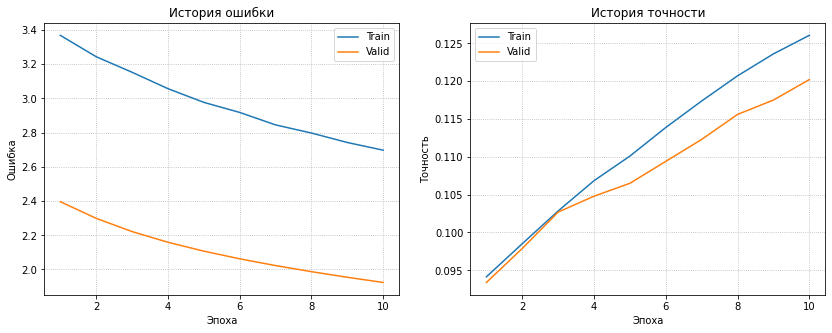

In [ ]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
dropout_model.eval()
for vecs, labels in test_dataloader:
    out = dropout_model.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.8926
Точность на тесте: 0.1248


In [ ]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.19      0.18      0.18      1000
           1       0.11      0.25      0.15      1000
           2       0.10      0.06      0.07      1000
           3       0.13      0.09      0.11      1000
           4       0.00      0.00      0.00      1000
           5       0.12      0.04      0.06      1000
           6       0.12      0.17      0.14      1000
           7       0.09      0.12      0.10      1000
           8       0.14      0.08      0.10      1000
           9       0.14      0.27      0.19      1000

    accuracy                           0.12     10000
   macro avg       0.11      0.12      0.11     10000
weighted avg       0.11      0.12      0.11     10000



### Эксперимент 5 Построение нейронной сети с Batchnorm слоем

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации, слои на ваше усмотрение, но указанный в эксперименте слой должен быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.   

In [19]:
np.random.seed(42)

In [20]:
# проверка градиентов:
check_model = Sequential(
    Linear(3072, 128),
    ReLU(),
    Linear(128, 20),
    BatchNorm(20),
    ReLU(),
    Linear(20, 10)
)
check_model

Sequential(
	Linear(3072, 128, bias=True),
	ReLU(),
	Linear(128, 20, bias=True),
	BatchNorm(in_dim=20, eps=1e-05),
	ReLU(),
	Linear(20, 10, bias=True)
)

In [ ]:
x, y = Dataloader(train_data, batch_size=2).__next__()
print(f"Проверка{' не пройдена' if not gradient_check(x, y, check_model) else ' пройдена'}")

Проверка пройдена                                                                   15s>139s                                             ] 442/393216 0s>863s] 445/393216 0s>864s1s>851s 1s>851s1s>847s>                                                 ] 735/393216 1s>845s                                                 ] 930/393216 1s>838s>                                                 ] 1216/393216 2s>839s2s>838s 2s>839s2s>840s2s>840s 3s>847s1545/393216 3s>860s1618/393216 3s>870s>                                                 ] 1693/393216 3s>879s>                                                 ] 1701/393216 3s>880s                                                 ] 1715/393216 3s>880s>                                                 ] 1763/393216 3s>887s1773/393216 4s>889s] 1834/393216 4s>896s 4s>895s] 1844/393216 4s>897s 4s>903s 4s>906s                                                 ] 1979/393216 4s>910s4s>915s 4s>915s5s>914s>                                                 ] 2225

In [22]:
# реальная модель
batchnorm_model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 64),
    BatchNorm(64),
    ReLU(),
    Linear(64, 10)
)
batchnorm_model

Sequential(
	Linear(3072, 128, bias=True),
	ReLU(),
	Linear(128, 20, bias=True),
	BatchNorm(in_dim=20, eps=1e-05),
	ReLU(),
	Linear(20, 10, bias=True)
)

In [23]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=batchnorm_model, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000,
    optim_method="GD")

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.4376  | 0.1071  |  1.8759  | 0.1097  | 0.164142 |   3.5    |   3.5    |
| 2/10|  1.4315  | 0.1082  |  1.6322  | 0.1088  | 0.096589 |   3.5    |   7.0    |
| 3/10|  1.4257  | 0.1090  |  1.5352  | 0.1106  | 0.055842 |   3.9    |   10.9   |
| 4/10|  1.4198  | 0.1095  |  1.4843  | 0.1118  | 0.040143 |   3.7    |   14.6   |
| 5/10|  1.4141  | 0.1098  |  1.4536  | 0.1132  | 0.040390 |   3.3    |   17.9   |
| 6/10|  1.4085  | 0.1102  |  1.4335  | 0.1143  | 0.041630 |   3.1    |   20.9   |
| 7/10|  1.4030  | 0.1109  |  1.4192  | 0.1137  | 0.040098 |   3.2    |   24.2   |
| 8/10|  1.3977  | 0.1122  |  1.4084  | 0.1151  | 0.031145 |   2.7    |   26.9   |
| 9/10|  1.3925  | 0.1129  |  1.3998  | 0.1153  | 0.021270 |   3.2    |   30.1   |
|10/10|  1.3875  | 0.1129  |  1.3926  | 0.1163  | 0.035909 |   2.8    |   32.9   |


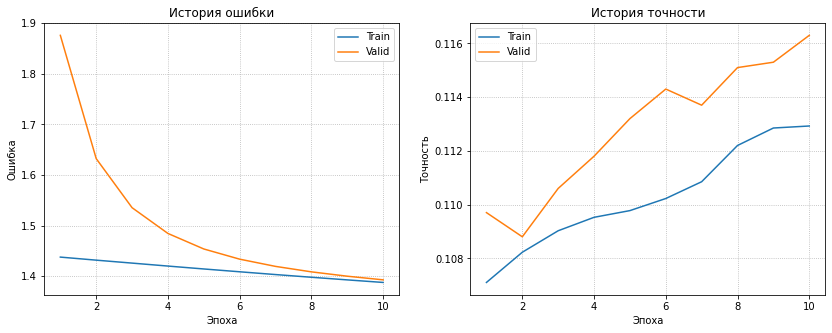

In [24]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [25]:
test_dataloader = Dataloader(test_data, len(test_data), False)
batchnorm_model.eval()
for vecs, labels in test_dataloader:
    out = batchnorm_model.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.3850
Точность на тесте: 0.1132


In [26]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.07      0.03      0.04      1000
           1       0.12      0.09      0.11      1000
           2       0.12      0.09      0.11      1000
           3       0.10      0.09      0.09      1000
           4       0.24      0.04      0.07      1000
           5       0.10      0.03      0.05      1000
           6       0.16      0.19      0.18      1000
           7       0.10      0.52      0.17      1000
           8       0.04      0.00      0.00      1000
           9       0.15      0.04      0.07      1000

    accuracy                           0.11     10000
   macro avg       0.12      0.11      0.09     10000
weighted avg       0.12      0.11      0.09     10000



### Эксперимент 6 Эксперимент с Adam оптимизатором 

Обучите вашу нейронную сеть с Adam оптимизатором. Подбор гиперпараметров на ваше усмотрение. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.   

In [18]:
np.random.seed(42)

In [19]:
# проверка градиентов:
check_model = Sequential(
    Linear(3072, 128),
    ReLU(),
    Dropout(p=0.1),
    Linear(128, 20),
    BatchNorm(20),
    ReLU(),
    Linear(20, 10)
)
check_model

Sequential(
	Linear(3072, 128, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(128, 20, bias=True),
	BatchNorm(in_dim=20, eps=1e-05),
	ReLU(),
	Linear(20, 10, bias=True)
)

In [ ]:
x, y = Dataloader(train_data, batch_size=2).__next__()
print(f"Проверка{' не пройдена' if not gradient_check(x, y, check_model) else ' пройдена'}")

Проверка пройдена                                                                           /393216 0s>748s>                                                 ] 312/393216 0s>750s>                                                 ] 416/393216 0s>750s>                                                 ] 418/393216 0s>749s624/393216 1s>751s] 626/393216 1s>752s730/393216 1s>750s>                                                 ] 731/393216 1s>750s1s>749s>                                                 ] 840/393216 1s>748s] 940/393216 1s>749s                                                 ] 943/393216 1s>749s>                                                 ] 1042/393216 1s>751s                                                 ] 1044/393216 2s>752s1046/393216 2s>753s 2s>763s] 1131/393216 2s>763s2s>763s>                                                 ] 1134/393216 2s>764s>                                                 ] 1228/393216 2s>766s                                                 ] 12

In [21]:
# реальная модель
adam_model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Dropout(p=0.1),
    Linear(768, 64),
    BatchNorm(64),
    ReLU(),
    Linear(64, 10)
)
adam_model

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(768, 64, bias=True),
	BatchNorm(in_dim=64, eps=1e-05),
	ReLU(),
	Linear(64, 10, bias=True)
)

In [22]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=adam_model, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.1722  | 0.2712  |  1.2460  | 0.2640  | 0.003117 |   4.6    |   4.6    |
| 2/10|  1.0705  | 0.3028  |  1.1073  | 0.2975  | 0.001517 |   4.4    |   9.0    |
| 3/10|  1.0456  | 0.3300  |  1.0617  | 0.3202  | 0.000491 |   3.8    |   12.9   |
| 4/10|  1.0336  | 0.3318  |  1.0436  | 0.3213  | 0.000269 |   4.4    |   17.3   |
| 5/10|  1.0256  | 0.3284  |  1.0333  | 0.3197  | 0.000412 |   3.8    |   21.1   |
| 6/10|  1.0205  | 0.3493  |  1.0239  | 0.3389  | 0.000189 |   4.4    |   25.5   |
| 7/10|  1.0167  | 0.3530  |  1.0187  | 0.3415  | 0.000282 |   4.4    |   29.9   |
| 8/10|  1.0140  | 0.3533  |  1.0153  | 0.3409  | 0.000141 |   3.9    |   33.8   |
| 9/10|  1.0117  | 0.3681  |  1.0118  | 0.3542  | 0.000127 |   4.1    |   37.9   |
|10/10|  1.0098  | 0.3750  |  1.0096  | 0.3591  | 0.000123 |   3.9    |   41.8   |


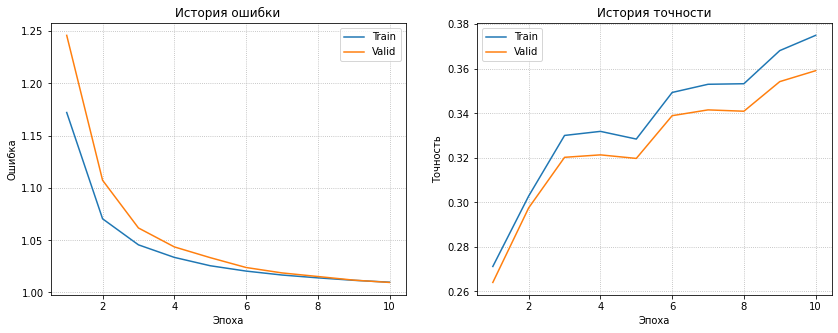

In [23]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [24]:
test_dataloader = Dataloader(test_data, len(test_data), False)
adam_model.eval()
for vecs, labels in test_dataloader:
    out = adam_model.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.0088
Точность на тесте: 0.3675


In [25]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.36      0.54      0.43      1000
           1       0.42      0.39      0.41      1000
           2       0.32      0.14      0.20      1000
           3       0.31      0.07      0.12      1000
           4       0.34      0.27      0.30      1000
           5       0.25      0.49      0.34      1000
           6       0.38      0.38      0.38      1000
           7       0.51      0.32      0.40      1000
           8       0.46      0.53      0.49      1000
           9       0.39      0.53      0.45      1000

    accuracy                           0.37     10000
   macro avg       0.37      0.37      0.35     10000
weighted avg       0.37      0.37      0.35     10000



Плюс посмотрим на модель без dropout и batchnorm слоев

In [28]:
# реальная модель
adam_model_2 = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 64),
    ReLU(),
    Linear(64, 10)
)
adam_model_2

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 64, bias=True),
	ReLU(),
	Linear(64, 10, bias=True)
)

In [29]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=adam_model_2, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  3.9485  | 0.1923  |  3.8943  | 0.1924  | 0.008461 |   3.2    |   3.2    |
| 2/10|  2.8766  | 0.2493  |  2.2834  | 0.2541  | 0.004968 |   3.0    |   6.3    |
| 3/10|  2.0382  | 0.2778  |  1.7268  | 0.2709  | 0.002403 |   3.2    |   9.4    |
| 4/10|  1.6078  | 0.2626  |  1.4418  | 0.2539  | 0.001894 |   3.0    |   12.4   |
| 5/10|  1.3173  | 0.2250  |  1.1831  | 0.2128  | 0.002443 |   2.9    |   15.4   |
| 6/10|  1.1234  | 0.2061  |  1.0730  | 0.1978  | 0.005042 |   3.4    |   18.8   |
| 7/10|  1.0462  | 0.1612  |  1.0317  | 0.1580  | 0.007254 |   2.9    |   21.7   |
| 8/10|  1.0179  | 0.1400  |  1.0147  | 0.1361  | 0.008959 |   3.2    |   25.0   |
| 9/10|  1.0074  | 0.1317  |  1.0093  | 0.1288  | 0.008548 |   3.1    |   28.1   |
|10/10|  1.0039  | 0.1346  |  1.0065  | 0.1286  | 0.008097 |   2.9    |   31.0   |


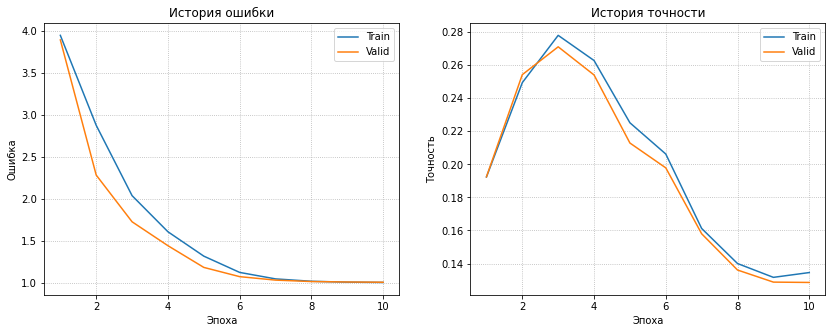

In [30]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [31]:
test_dataloader = Dataloader(test_data, len(test_data), False)
adam_model_2.eval()
for vecs, labels in test_dataloader:
    out = adam_model_2.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.0042
Точность на тесте: 0.1300


In [32]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.38      0.03      0.06      1000
           1       0.51      0.08      0.13      1000
           2       0.10      0.93      0.18      1000
           3       0.15      0.01      0.01      1000
           4       0.23      0.01      0.02      1000
           5       0.42      0.07      0.12      1000
           6       0.13      0.01      0.01      1000
           7       0.66      0.10      0.17      1000
           8       0.37      0.05      0.08      1000
           9       0.23      0.03      0.05      1000

    accuracy                           0.13     10000
   macro avg       0.32      0.13      0.08     10000
weighted avg       0.32      0.13      0.08     10000



### Эксперимент 7 Эксперимент c количеством слоев

Зафиксируйте модель и начинайте добавлять слои. Как меняется качество модели?

In [19]:
np.random.seed(42)

Рассмотрим влияние количества слоев на примере последней модели с BatchNorm, Dropout и Adam оптимизатором (она тут лучше всех оказалась)

#### База: двухслойная модель

In [20]:
# two layers
model_2 = Sequential(
    Linear(3072, 768),
    ReLU(),
    Dropout(p=0.1),
    Linear(768, 64),
    BatchNorm(64),
    ReLU(),
    Linear(64, 10)
)
model_2

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(768, 64, bias=True),
	BatchNorm(in_dim=64, eps=1e-05),
	ReLU(),
	Linear(64, 10, bias=True)
)

In [21]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model_2, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.1722  | 0.2712  |  1.2460  | 0.2640  | 0.003117 |   6.3    |   6.3    |
| 2/10|  1.0705  | 0.3028  |  1.1073  | 0.2975  | 0.001517 |   6.1    |   12.4   |
| 3/10|  1.0456  | 0.3300  |  1.0617  | 0.3202  | 0.000491 |   6.6    |   19.0   |
| 4/10|  1.0336  | 0.3318  |  1.0436  | 0.3213  | 0.000269 |   6.0    |   25.0   |
| 5/10|  1.0256  | 0.3284  |  1.0333  | 0.3197  | 0.000412 |   6.5    |   31.5   |
| 6/10|  1.0205  | 0.3493  |  1.0239  | 0.3389  | 0.000189 |   6.6    |   38.1   |
| 7/10|  1.0167  | 0.3530  |  1.0187  | 0.3415  | 0.000282 |   6.3    |   44.4   |
| 8/10|  1.0140  | 0.3533  |  1.0153  | 0.3409  | 0.000141 |   6.5    |   50.9   |
| 9/10|  1.0117  | 0.3681  |  1.0118  | 0.3542  | 0.000127 |   6.7    |   57.6   |
|10/10|  1.0098  | 0.3750  |  1.0096  | 0.3591  | 0.000123 |   6.4    |   64.0   |


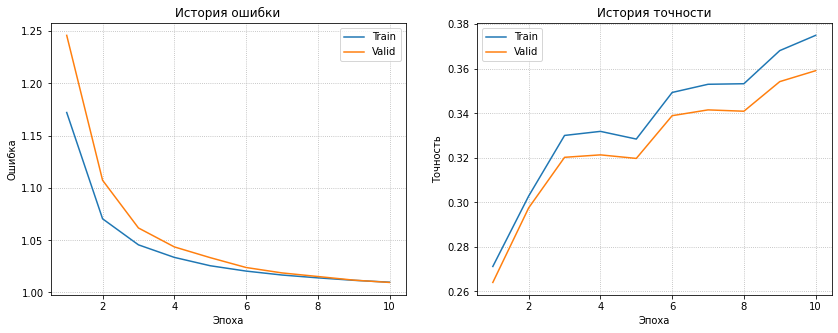

In [22]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [23]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model_2.eval()
for vecs, labels in test_dataloader:
    out = model_2.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.0088
Точность на тесте: 0.3675


In [24]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.36      0.54      0.43      1000
           1       0.42      0.39      0.41      1000
           2       0.32      0.14      0.20      1000
           3       0.31      0.07      0.12      1000
           4       0.34      0.27      0.30      1000
           5       0.25      0.49      0.34      1000
           6       0.38      0.38      0.38      1000
           7       0.51      0.32      0.40      1000
           8       0.46      0.53      0.49      1000
           9       0.39      0.53      0.45      1000

    accuracy                           0.37     10000
   macro avg       0.37      0.37      0.35     10000
weighted avg       0.37      0.37      0.35     10000



#### Модель три слоя

In [26]:
# three layers
model_3 = Sequential(
    Linear(3072, 768),
    ReLU(),
    Dropout(p=0.1),
    Linear(768, 384),
    BatchNorm(384),
    ReLU(),
    Dropout(p=0.1),
    Linear(384, 64),
    BatchNorm(64),
    ReLU(),
    Linear(64, 10)
)
model_3

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(768, 384, bias=True),
	BatchNorm(in_dim=384, eps=1e-05),
	ReLU(),
	Dropout(p=0.1),
	Linear(384, 64, bias=True),
	BatchNorm(in_dim=64, eps=1e-05),
	ReLU(),
	Linear(64, 10, bias=True)
)

In [27]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model_3, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.1752  | 0.2701  |  1.4971  | 0.2645  | 0.003940 |   8.8    |   8.8    |
| 2/10|  1.0747  | 0.3255  |  1.1687  | 0.3127  | 0.001200 |   8.6    |   17.3   |
| 3/10|  1.0436  | 0.3429  |  1.0831  | 0.3331  | 0.000355 |   8.3    |   25.6   |
| 4/10|  1.0285  | 0.3668  |  1.0444  | 0.3525  | 0.000169 |   8.1    |   33.7   |
| 5/10|  1.0195  | 0.3689  |  1.0296  | 0.3591  | 0.000102 |   8.2    |   41.9   |
| 6/10|  1.0126  | 0.3838  |  1.0148  | 0.3750  | 0.000068 |   8.6    |   50.5   |
| 7/10|  1.0059  | 0.3898  |  1.0054  | 0.3766  | 0.000088 |   8.2    |   58.7   |
| 8/10|  0.9999  | 0.3938  |  0.9971  | 0.3826  | 0.000078 |   8.0    |   66.7   |
| 9/10|  0.9946  | 0.4006  |  0.9916  | 0.3820  | 0.000083 |   7.7    |   74.4   |
|10/10|  0.9893  | 0.4124  |  0.9859  | 0.3958  | 0.000084 |   8.2    |   82.7   |


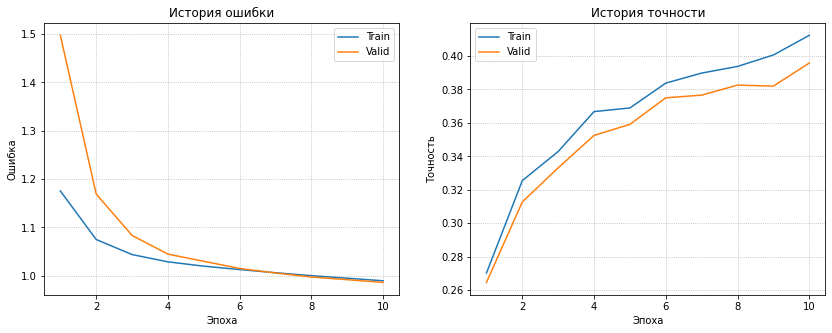

In [28]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [29]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model_3.eval()
for vecs, labels in test_dataloader:
    out = model_3.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 0.9848
Точность на тесте: 0.4028


In [30]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.49      0.47      0.48      1000
           1       0.50      0.48      0.49      1000
           2       0.26      0.28      0.27      1000
           3       0.28      0.19      0.23      1000
           4       0.30      0.26      0.28      1000
           5       0.32      0.36      0.34      1000
           6       0.45      0.32      0.37      1000
           7       0.39      0.55      0.46      1000
           8       0.51      0.62      0.56      1000
           9       0.49      0.51      0.50      1000

    accuracy                           0.40     10000
   macro avg       0.40      0.40      0.40     10000
weighted avg       0.40      0.40      0.40     10000



#### Модель четыре слоя

In [32]:
# four layers
model_4 = Sequential(
    Linear(3072, 768),
    ReLU(),
    Dropout(p=0.1),
    Linear(768, 384),
    BatchNorm(384),
    ReLU(),
    Dropout(p=0.1),
    Linear(384, 64),
    BatchNorm(64),
    ReLU(),
    Dropout(p=0.1),
    Linear(64, 32),
    BatchNorm(32),
    ReLU(),
    Linear(32, 10)
)
model_4

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(768, 384, bias=True),
	BatchNorm(in_dim=384, eps=1e-05),
	ReLU(),
	Dropout(p=0.1),
	Linear(384, 64, bias=True),
	BatchNorm(in_dim=64, eps=1e-05),
	ReLU(),
	Dropout(p=0.1),
	Linear(64, 32, bias=True),
	BatchNorm(in_dim=32, eps=1e-05),
	ReLU(),
	Linear(32, 10, bias=True)
)

In [33]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model_4, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.1517  | 0.2252  |  2.0360  | 0.2180  | 0.001338 |   8.7    |   8.7    |
| 2/10|  1.0767  | 0.2625  |  1.2904  | 0.2587  | 0.000483 |   8.8    |   17.5   |
| 3/10|  1.0541  | 0.3122  |  1.1215  | 0.3054  | 0.000288 |   8.2    |   25.7   |aluating valid: [>                                                 ] 0/1 0s>0s
| 4/10|  1.0410  | 0.3297  |  1.0671  | 0.3219  | 0.000140 |   8.4    |   34.2   |
| 5/10|  1.0316  | 0.3414  |  1.0422  | 0.3252  | 0.000149 |   8.6    |   42.8   |
| 6/10|  1.0247  | 0.3515  |  1.0265  | 0.3362  | 0.000142 |   8.7    |   51.5   |
| 7/10|  1.0194  | 0.3586  |  1.0150  | 0.3390  | 0.000144 |   8.5    |   60.0   |s
| 8/10|  1.0133  | 0.3605  |  1.0093  | 0.3405  | 0.000110 |   8.8    |   68.7   |
| 9/10|  1.0076  | 0.3691  |  1.0027  | 0.3498  | 0.000107 |   8.5    |   77.2   |
|10/10| 

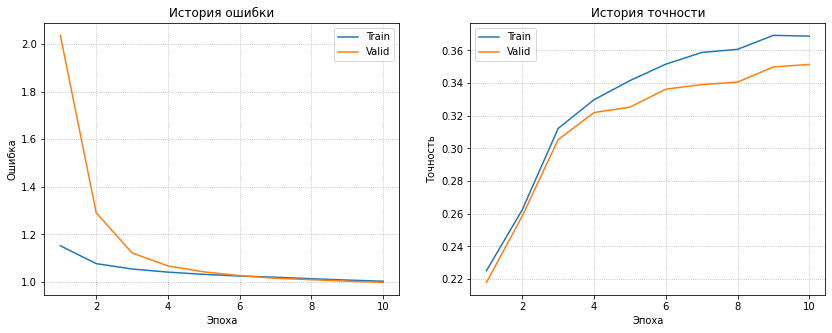

In [34]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [35]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model_4.eval()
for vecs, labels in test_dataloader:
    out = model_4.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 0.9958
Точность на тесте: 0.3528


In [36]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.40      0.51      0.45      1000
           1       0.50      0.35      0.41      1000
           2       0.20      0.19      0.20      1000
           3       0.24      0.12      0.16      1000
           4       0.20      0.09      0.12      1000
           5       0.39      0.29      0.33      1000
           6       0.26      0.61      0.37      1000
           7       0.47      0.41      0.44      1000
           8       0.48      0.54      0.51      1000
           9       0.40      0.42      0.41      1000

    accuracy                           0.35     10000
   macro avg       0.35      0.35      0.34     10000
weighted avg       0.35      0.35      0.34     10000



#### Модель пять слоев

In [37]:
# four layers
model_5 = Sequential(
    Linear(3072, 768),
    ReLU(),
    Dropout(p=0.1),
    Linear(768, 384),
    BatchNorm(384),
    ReLU(),
    Dropout(p=0.1),
    Linear(384, 64),
    BatchNorm(64),
    ReLU(),
    Dropout(p=0.1),
    Linear(64, 384),
    BatchNorm(384),
    ReLU(),
    Dropout(p=0.1),
    Linear(384, 20),
    BatchNorm(20),
    ReLU(),
    Linear(20, 10),
)
model_5

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(768, 384, bias=True),
	BatchNorm(in_dim=384, eps=1e-05),
	ReLU(),
	Dropout(p=0.1),
	Linear(384, 64, bias=True),
	BatchNorm(in_dim=64, eps=1e-05),
	ReLU(),
	Dropout(p=0.1),
	Linear(64, 384, bias=True),
	BatchNorm(in_dim=384, eps=1e-05),
	ReLU(),
	Dropout(p=0.1),
	Linear(384, 20, bias=True),
	BatchNorm(in_dim=20, eps=1e-05),
	ReLU(),
	Linear(20, 10, bias=True)
)

In [38]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model_5, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.3219  | 0.1683  |  6.2002  | 0.1705  | 0.002101 |   10.9   |   10.9   |
| 2/10|  1.1327  | 0.2026  |  2.2731  | 0.1965  | 0.000614 |   10.6   |   21.6   |
| 3/10|  1.0818  | 0.2506  |  1.4813  | 0.2414  | 0.000506 |   10.6   |   32.2   |         ] 3/4 5s>1s
| 4/10|  1.0563  | 0.2602  |  1.2362  | 0.2564  | 0.000575 |   10.3   |   42.5   |
| 5/10|  1.0394  | 0.2754  |  1.1137  | 0.2679  | 0.000492 |   10.3   |   52.8   |
| 6/10|  1.0264  | 0.2658  |  1.0560  | 0.2618  | 0.000546 |   10.7   |   63.6   |
| 7/10|  1.0174  | 0.2649  |  1.0240  | 0.2620  | 0.000468 |   10.2   |   73.7   |
| 8/10|  1.0090  | 0.2596  |  1.0065  | 0.2558  | 0.000874 |   10.3   |   84.0   |
| 9/10|  1.0012  | 0.2539  |  0.9960  | 0.2533  | 0.001088 |   10.3   |   94.4   |
|10/10|  0.9959  | 0.2369  |  0.9901  | 0.2289  | 0.001069 |   11.3

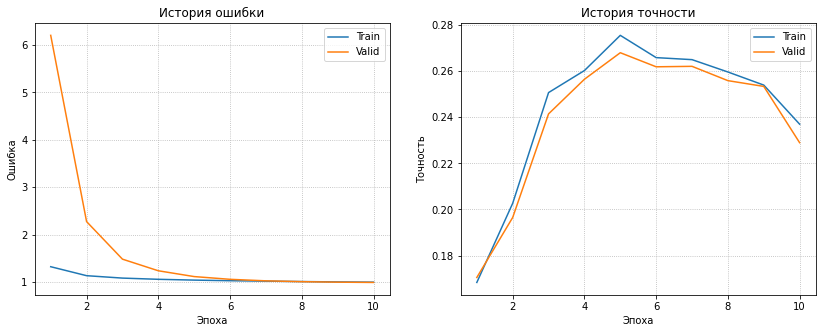

In [39]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [40]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model_5.eval()
for vecs, labels in test_dataloader:
    out = model_5.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 0.9885
Точность на тесте: 0.2356


In [41]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.59      0.36      0.45      1000
           1       0.14      0.51      0.22      1000
           2       0.17      0.04      0.06      1000
           3       0.15      0.03      0.05      1000
           4       0.13      0.37      0.19      1000
           5       0.46      0.10      0.17      1000
           6       0.00      0.00      0.00      1000
           7       0.13      0.04      0.06      1000
           8       0.59      0.52      0.55      1000
           9       0.43      0.38      0.40      1000

    accuracy                           0.24     10000
   macro avg       0.28      0.24      0.21     10000
weighted avg       0.28      0.24      0.21     10000



### Эксперимент 8 Эксперимент c количеством нейронов

Зафиксируйте модель и увеличьте количетсво весов в одном из слоев. Дает ли это прирост качества?

Рассмотрим все ту же модель из двух слоев с BatchNorm и Dropout + Adam  
и поэкспериментируем с нейронами в скрытых слоях

In [ ]:
np.random.seed(42)

In [42]:
# two layers and base
model_base = Sequential(
    Linear(3072, 768),
    ReLU(),
    Dropout(p=0.1),
    Linear(768, 64),
    BatchNorm(64),
    ReLU(),
    Linear(64, 10)
)
model_base

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(768, 64, bias=True),
	BatchNorm(in_dim=64, eps=1e-05),
	ReLU(),
	Linear(64, 10, bias=True)
)

In [43]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model_base, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.1688  | 0.2540  |  1.2461  | 0.2471  | 0.003394 |   7.5    |   7.5    |
| 2/10|  1.0659  | 0.3121  |  1.0960  | 0.3034  | 0.001362 |   5.8    |   13.4   |
| 3/10|  1.0419  | 0.3306  |  1.0606  | 0.3195  | 0.000532 |   6.4    |   19.7   |
| 4/10|  1.0317  | 0.3341  |  1.0430  | 0.3251  | 0.000420 |   6.0    |   25.8   |
| 5/10|  1.0245  | 0.3418  |  1.0310  | 0.3324  | 0.000221 |   6.4    |   32.2   |
| 6/10|  1.0198  | 0.3649  |  1.0220  | 0.3518  | 0.000172 |   6.3    |   38.5   |
| 7/10|  1.0159  | 0.3839  |  1.0158  | 0.3650  | 0.000251 |   6.3    |   44.7   |
| 8/10|  1.0130  | 0.3915  |  1.0131  | 0.3710  | 0.000162 |   6.1    |   50.9   |
| 9/10|  1.0110  | 0.4015  |  1.0106  | 0.3823  | 0.000124 |   5.7    |   56.5   |
|10/10|  1.0094  | 0.4129  |  1.0083  | 0.3931  | 0.000115 |   6.1    |   62.6   |


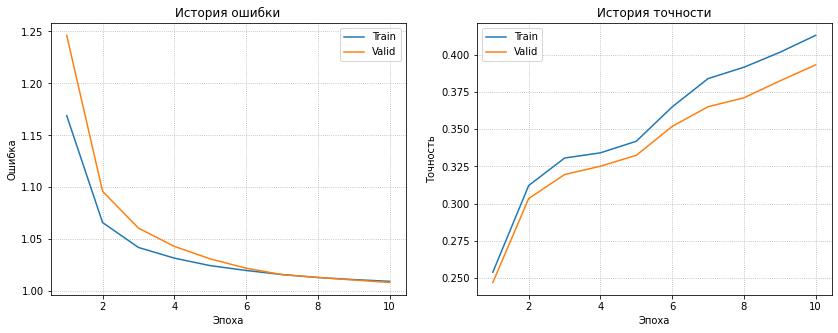

In [44]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [45]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model_base.eval()
for vecs, labels in test_dataloader:
    out = model_base.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.0080
Точность на тесте: 0.3968


In [46]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.44      0.45      0.44      1000
           1       0.47      0.43      0.45      1000
           2       0.34      0.24      0.28      1000
           3       0.30      0.26      0.28      1000
           4       0.40      0.23      0.30      1000
           5       0.31      0.39      0.35      1000
           6       0.47      0.39      0.43      1000
           7       0.37      0.52      0.43      1000
           8       0.45      0.62      0.52      1000
           9       0.41      0.44      0.42      1000

    accuracy                           0.40     10000
   macro avg       0.40      0.40      0.39     10000
weighted avg       0.40      0.40      0.39     10000



In [47]:
# two layers and new_1
model_new_1 = Sequential(
    Linear(3072, 1024),
    ReLU(),
    Dropout(p=0.1),
    Linear(1024, 512),
    BatchNorm(512),
    ReLU(),
    Linear(512, 10)
)
model_new_1

Sequential(
	Linear(3072, 1024, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(1024, 512, bias=True),
	BatchNorm(in_dim=512, eps=1e-05),
	ReLU(),
	Linear(512, 10, bias=True)
)

In [48]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model_new_1, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.0688  | 0.2859  |  1.1244  | 0.2766  | 0.002852 |   9.7    |   9.7    |
| 2/10|  1.0255  | 0.3442  |  1.0377  | 0.3363  | 0.002278 |   9.6    |   19.4   |
| 3/10|  1.0128  | 0.3639  |  1.0199  | 0.3487  | 0.002378 |   9.6    |   29.0   |
| 4/10|  1.0082  | 0.3796  |  1.0112  | 0.3634  | 0.002139 |   9.7    |   38.7   |
| 5/10|  1.0049  | 0.3952  |  1.0062  | 0.3776  | 0.001661 |   9.8    |   48.5   |
| 6/10|  1.0027  | 0.4185  |  1.0027  | 0.3954  | 0.001364 |   9.7    |   58.1   |
| 7/10|  1.0014  | 0.4319  |  1.0006  | 0.4075  | 0.001211 |   9.6    |   67.7   |
| 8/10|  0.9999  | 0.4429  |  0.9992  | 0.4132  | 0.000867 |   9.7    |   77.4   |
| 9/10|  0.9986  | 0.4398  |  0.9983  | 0.4106  | 0.001015 |   9.8    |   87.3   |
|10/10|  0.9973  | 0.4498  |  0.9973  | 0.4193  | 0.000552 |   9.7    |   97.0   |


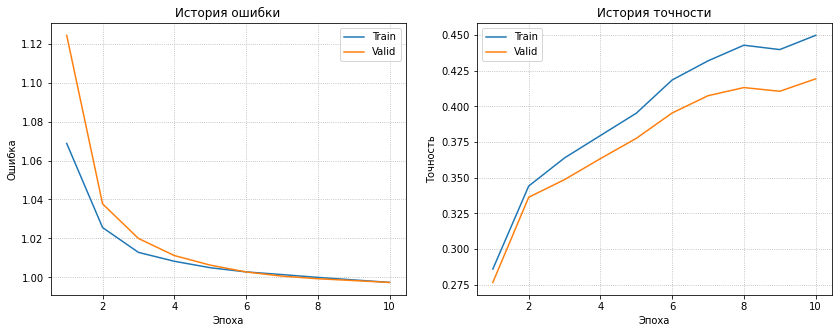

In [49]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [50]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model_new_1.eval()
for vecs, labels in test_dataloader:
    out = model_new_1.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 0.9967
Точность на тесте: 0.4291


In [51]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.43      0.56      0.49      1000
           1       0.48      0.53      0.51      1000
           2       0.33      0.32      0.32      1000
           3       0.29      0.37      0.32      1000
           4       0.45      0.25      0.32      1000
           5       0.41      0.32      0.36      1000
           6       0.48      0.43      0.45      1000
           7       0.47      0.47      0.47      1000
           8       0.49      0.61      0.55      1000
           9       0.48      0.44      0.46      1000

    accuracy                           0.43     10000
   macro avg       0.43      0.43      0.42     10000
weighted avg       0.43      0.43      0.42     10000



In [52]:
# two layers and new_1
model_new_2 = Sequential(
    Linear(3072, 324),
    ReLU(),
    Dropout(p=0.1),
    Linear(324, 768),
    BatchNorm(768),
    ReLU(),
    Linear(768, 10)
)
model_new_2

Sequential(
	Linear(3072, 324, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(324, 768, bias=True),
	BatchNorm(in_dim=768, eps=1e-05),
	ReLU(),
	Linear(768, 10, bias=True)
)

In [53]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model_new_2, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.0477  | 0.3111  |  1.0620  | 0.3029  | 0.002417 |   8.3    |   8.3    |
| 2/10|  1.0191  | 0.3364  |  1.0264  | 0.3300  | 0.001803 |   8.2    |   16.5   |                                               ] 0/1 0s>0s
| 3/10|  1.0121  | 0.3684  |  1.0143  | 0.3627  | 0.001585 |   8.1    |   24.5   |
| 4/10|  1.0080  | 0.3912  |  1.0084  | 0.3753  | 0.001404 |   7.7    |   32.3   |
| 5/10|  1.0054  | 0.4010  |  1.0046  | 0.3777  | 0.001166 |   8.4    |   40.6   |
| 6/10|  1.0030  | 0.4146  |  1.0019  | 0.3953  | 0.001408 |   8.4    |   49.1   |
| 7/10|  1.0011  | 0.4245  |  1.0001  | 0.4009  | 0.000910 |   8.1    |   57.1   |
| 8/10|  0.9996  | 0.4374  |  0.9983  | 0.4121  | 0.000984 |   8.0    |   65.1   |
| 9/10|  0.9980  | 0.4459  |  0.9968  | 0.4159  | 0.001301 |   7.7    |   72.8   |
|10/10|  0.9960  | 0.4542  | 

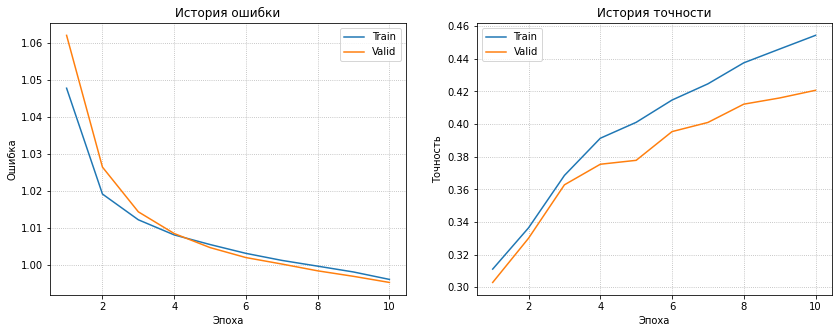

In [54]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

In [55]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model_new_2.eval()
for vecs, labels in test_dataloader:
    out = model_new_2.forward(vecs)

    loss = loss_functions.hinge_loss.hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 0.9948
Точность на тесте: 0.4292


In [56]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.43      0.57      0.49      1000
           1       0.53      0.51      0.52      1000
           2       0.33      0.29      0.31      1000
           3       0.33      0.14      0.20      1000
           4       0.40      0.27      0.32      1000
           5       0.36      0.40      0.38      1000
           6       0.49      0.47      0.48      1000
           7       0.43      0.54      0.48      1000
           8       0.47      0.64      0.54      1000
           9       0.46      0.47      0.46      1000

    accuracy                           0.43     10000
   macro avg       0.42      0.43      0.42     10000
weighted avg       0.42      0.43      0.42     10000



### Эксперимент 9 Эксперимент c размером батча

Зафиксируйте модель и обучитесь на разных размерах. Как размер батча влияет на процесс обучения?

### Эксперимент 10 Эксперимент с регуляризацией

Добавьте в процесс обучения L1/L2 регуляризацию. Повлияло ли это на качесвто? Выведите норму весов без регуляризации и с. 

### Эксперимент 11 Финальная архитектура

Как выглядит ваша финальная модель?